In [ ]:
# install dependencies
!pip install --quiet numpy==1.23.5 lightgbm
!pip install --quiet pytorch-forecasting


In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import kagglehub
data_path = kagglehub.dataset_download("imranbukhari/comprehensive-btcusd-1h-data")
print(f"Dataset path: {data_path}")

# find the CSV file
csv_files = [f for f in os.listdir(data_path) if f.lower().endswith('.csv')]
if not csv_files:
    raise FileNotFoundError(f"No CSV found in {data_path}")
csv_file = csv_files[0]

# load CSV, parsing the 'Open time' column as datetime index
df = pd.read_csv(
    os.path.join(data_path, csv_file),
    parse_dates=['Open time'],
    index_col='Open time'
).sort_index()

# rename the index to 'Date' for consistency downstream
df.index.name = 'Date'


print(df.columns.tolist())
df.head()



Dataset path: /kaggle/input/comprehensive-btcusd-1h-data
['Open', 'Close', 'High', 'Low', 'Volume']


,Open,Close,High,Low,Volume
Date,,,,,
2011-08-18 12:37:00,10.9,10.9,10.9,10.9,0.489908
2011-08-18 13:00:00,10.9,10.9,10.9,10.9,0.000000
2011-08-18 14:00:00,10.9,10.9,10.9,10.9,0.000000
2011-08-18 15:00:00,10.9,10.9,10.9,10.9,0.000000
2011-08-18 16:00:00,10.9,10.9,10.9,10.9,0.000000


In [ ]:
# ─── 1. Compute daily features: rv_5d, volume, MA, RSI, ATR ──────────────
import numpy as np

# daily Close series + log‐return + rv_5d
daily = df["Close"].resample("1D").last().to_frame()
daily["log_return"] = np.log(daily["Close"] / daily["Close"].shift(1))
daily["rv_5d"]      = daily["log_return"].rolling(5).std() * np.sqrt(252)

# volume & rv_5d MA
daily["volume"]   = df["Volume"].resample("1D").sum()
daily["rv_5d_ma"] = daily["rv_5d"].rolling(5).mean()

# RSI (14‑day)
delta    = df["Close"].diff()
gain     = delta.clip(lower=0)
loss     = (-delta).clip(lower=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs       = avg_gain / avg_loss
rsi      = 100 - (100 / (1 + rs))
daily["rsi"] = rsi.resample("1D").last()

# ATR (14‑day)
high = df["High"]; low = df["Low"]; close = df["Close"]
tr1  = high - low
tr2  = (high - close.shift()).abs()
tr3  = (low  - close.shift()).abs()
tr   = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
atr  = tr.rolling(14).mean()
daily["atr"] = atr.resample("1D").last()

# drop initial NaNs
daily.dropna(inplace=True)


In [ ]:
# train/val/test split
train = daily.iloc[: -60]
val   = daily.iloc[-60:-30]
test  = daily.iloc[-30:]


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
 # 2. ARIMA on the target series via statsmodels
order = (1, 0, 1)

arima_preds = []
history = list(train["rv_5d"])
for t in range(len(test)):
    # fit ARIMA on all data up to this point
    model = ARIMA(history, order=order).fit()
    # forecast one step ahead
    fc = model.forecast(steps=1)[0]
    arima_preds.append(fc)
    # append the true value so the next iteration has the expanded history
    history.append(test["rv_5d"].iloc[t])

# convert to a pandas Series aligned with test.index
arima_preds = pd.Series(arima_preds, index=test.index)


In [ ]:
# ─── 3. LightGBM with Lag & New Features ──────────────────────────────────
import lightgbm as lgb

def make_features(df):
    return pd.DataFrame({
        "lag1":     df["rv_5d"].shift(1),
        "lag2":     df["rv_5d"].shift(2),
        "vol_lag1": df["volume"].shift(1),
        "rv_ma":    df["rv_5d_ma"],
    }).dropna()

Xtr = make_features(train)
ytr = train.loc[Xtr.index, "rv_5d"]
Xv  = make_features(val)
yv  = val.loc[Xv.index, "rv_5d"]
Xt  = make_features(test)
yt  = test.loc[Xt.index, "rv_5d"]

lgbm = lgb.LGBMRegressor(n_estimators=200)
lgbm.fit(Xtr, ytr, eval_set=[(Xv, yv)], callbacks=[lgb.early_stopping(stopping_rounds=20)])
lgbm_preds = pd.Series(lgbm.predict(Xt), index=Xt.index)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4996, number of used features: 4
[LightGBM] [Info] Start training from score 0.529509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	valid_0's l2: 0.00463872


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5015, number of used features: 4
[LightGBM] [Info] Start training from score 0.158927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 5015, number of used features: 4
[LightGBM] [Info] Start training from score 1.001818


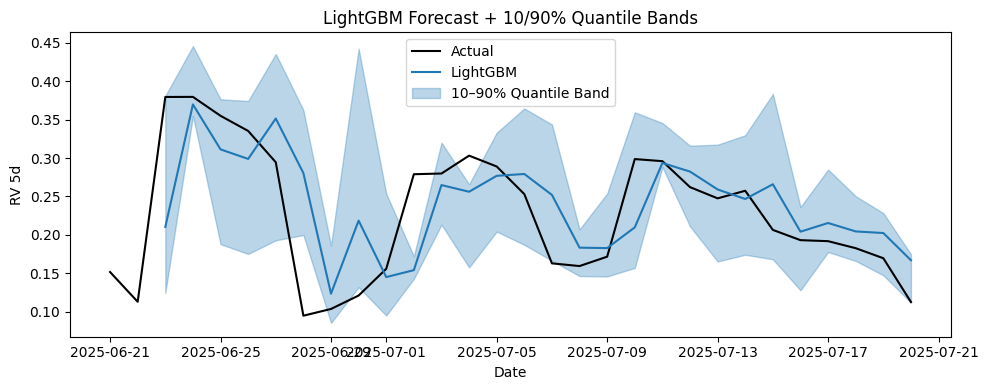

In [ ]:
# ───  LightGBM Quantile Regression for 10% & 90% bands ───────────────
lgb_low  = lgb.LGBMRegressor(objective="quantile", alpha=0.1, n_estimators=200)
lgb_high = lgb.LGBMRegressor(objective="quantile", alpha=0.9, n_estimators=200)

# fit on the same training data
lgb_low .fit(Xtr, ytr)
lgb_high.fit(Xtr, ytr)

# get lower/upper forecasts
q10 = pd.Series(lgb_low .predict(Xt), index=Xt.index, name="q10")
q90 = pd.Series(lgb_high.predict(Xt), index=Xt.index, name="q90")

# plot with shaded 10–90% interval
plt.figure(figsize=(10,4))
plt.plot(test["rv_5d"],       label="Actual", color="black")
plt.plot(lgbm_preds,          label="LightGBM", color="tab:blue")
plt.fill_between(
    Xt.index,
    q10,
    q90,
    color="tab:blue",
    alpha=0.3,
    label="10–90% Quantile Band"
)
plt.title("LightGBM Forecast + 10/90% Quantile Bands")
plt.xlabel("Date")
plt.ylabel("RV 5d")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
# ─── 4. Temporal Fusion Transformer ───────────────────────────────────────
import logging
import numpy as np
import pandas as pd
import torch
from pytorch_forecasting import (
    TimeSeriesDataSet,
    GroupNormalizer,
    TemporalFusionTransformer
)
from torchmetrics import MeanSquaredError
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping

#  Silence Lightning info/tips
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

#  Ensure `daily` has all features: rv_5d, volume, rv_5d_ma, rsi, atr
daily["time_idx"] = np.arange(len(daily))
daily["group"]    = "BTC"

# Split into train/validation/test sets
split       = int(len(daily) * 0.8)
train_data  = daily.iloc[:split].reset_index()
val_data    = daily.iloc[split:].reset_index()
test_data   = daily.iloc[-30:].reset_index()

# Build the TimeSeriesDataSet for a 1‑day forecast horizon
train_ds = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="rv_5d",
    group_ids=["group"],
    max_encoder_length=30,
    max_prediction_length=1,
    time_varying_unknown_reals=["rv_5d"],
    time_varying_known_reals=[
        "time_idx", "volume", "rv_5d_ma", "rsi", "atr"
    ],
    target_normalizer=GroupNormalizer(groups=["group"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=True,
)
val_ds = TimeSeriesDataSet.from_dataset(train_ds, val_data, predict=False)

train_loader = train_ds.to_dataloader(train=True,  batch_size=64, shuffle=True,  num_workers=0)
val_loader   = val_ds.to_dataloader(train=False, batch_size=64, shuffle=False, num_workers=0)

# Instantiate and train the TFT with early stopping
tft = TemporalFusionTransformer.from_dataset(
    train_ds,
    hidden_size=128,
    lstm_layers=2,
    attention_head_size=4,
    dropout=0.1,
    output_size=1,
    learning_rate=1e-4,
    loss=MeanSquaredError(),
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min"
)

trainer = Trainer(
    max_epochs=30,
    accelerator="auto",
    devices=1,
    callbacks=[early_stop],
    logger=False,
    enable_checkpointing=False,
    enable_progress_bar=False,
    enable_model_summary=False,
)
trainer.fit(tft, train_loader, val_loader)

# Rolling one‑step TFT forecast on test_data
tft_preds = []
enc_len   = train_ds.max_encoder_length
pred_len  = train_ds.max_prediction_length
date_col  = train_data.columns[0]

for idx in test_data["time_idx"].values:
    # encoder slice
    enc_df = daily[daily["time_idx"] <= idx].iloc[-enc_len:].reset_index()

    # build dummy decoder rows
    last_date    = enc_df[date_col].iloc[-1]
    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        periods=pred_len,
        freq="D"
    )
    future_idxs = np.arange(idx + 1, idx + 1 + pred_len)
    dummy_df = pd.DataFrame({
        date_col:   future_dates,
        "time_idx": future_idxs,
        "group":    enc_df["group"].iloc[0],
        "rv_5d":    0.0,
        "volume":   enc_df["volume"].iloc[-1],
        "rv_5d_ma": enc_df["rv_5d_ma"].iloc[-1],
        "rsi":      enc_df["rsi"].iloc[-1],
        "atr":      enc_df["atr"].iloc[-1],
    })

    # combine encoder + decoder into one DataFrame
    df_pred = pd.concat([
        enc_df[[date_col,"time_idx","group","rv_5d","volume","rv_5d_ma","rsi","atr"]],
        dummy_df
    ], ignore_index=True)

    # build a small prediction dataset & loader
    ds_pred    = TimeSeriesDataSet.from_dataset(
        train_ds, df_pred, predict=True, stop_randomization=True
    )
    loader_pred = ds_pred.to_dataloader(batch_size=1, num_workers=0, shuffle=False)

    # predict first step
    out = tft.predict(loader_pred)
    tft_preds.append(out.detach().cpu().numpy().flatten()[0])

# Align predictions with test dates
tft_preds = pd.Series(tft_preds, index=test_data[date_col], name="TFT")




/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pyto

In [36]:
print("Number of TFT predictions:", len(tft_preds))
print(tft_preds.head())


Number of TFT predictions: 30
Date
2025-06-21    0.165099
2025-06-22    0.148676
2025-06-23    0.253110
2025-06-24    0.253391
2025-06-25    0.214166
Name: TFT, dtype: float32


              RMSE      MAPE
Model                       
ARIMA     0.079539  0.325051
LightGBM  0.065769  0.258315
TFT       0.068778  0.227173 



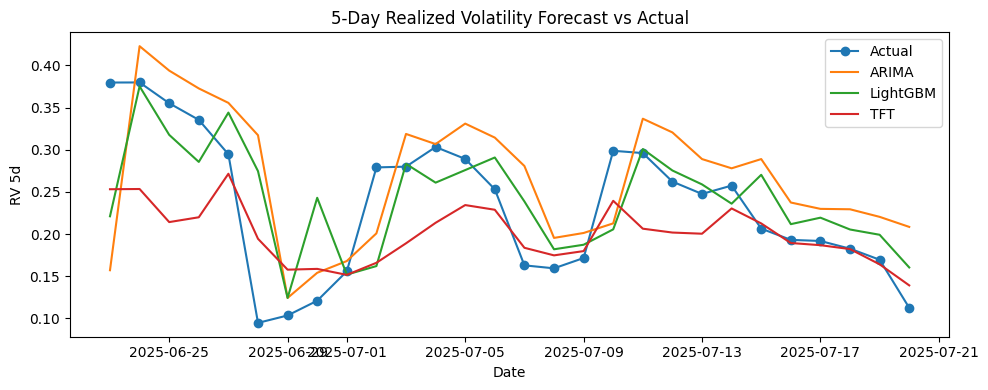

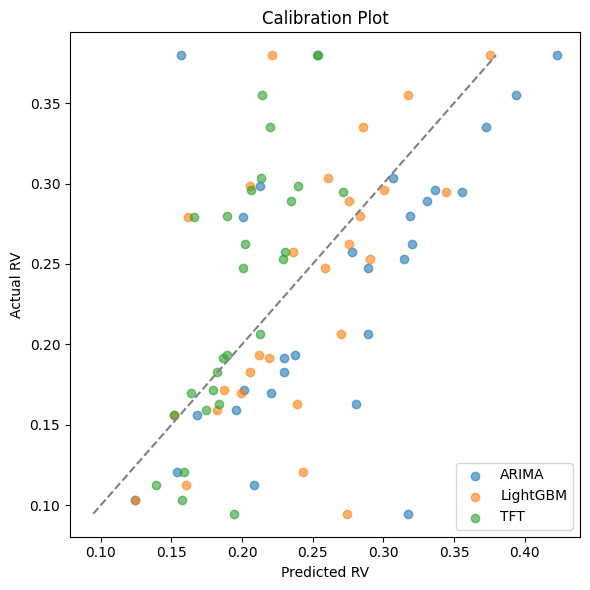

In [37]:
# ─── 5. Evaluation & Visualization ────────────────────────────────────────
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Combine forecasts into one DataFrame
preds = pd.DataFrame({
    "ARIMA":    arima_preds,
    "LightGBM": lgbm_preds,
    "TFT":      tft_preds
})

# Ground truth series
truth = test["rv_5d"]

# Restrict to dates where all models have a prediction:
common_idx     = preds.dropna().index
preds_complete = preds.loc[common_idx]
truth_complete = truth.loc[common_idx]

# Compute error metrics on the complete subset
results = []
for model in preds_complete.columns:
    y_pred = preds_complete[model]
    y_true = truth_complete
    rmse   = np.sqrt(mean_squared_error(y_true, y_pred))
    mape   = mean_absolute_percentage_error(y_true, y_pred)
    results.append({"Model": model, "RMSE": rmse, "MAPE": mape})
res_df = pd.DataFrame(results).set_index("Model")
print(res_df, "\n")

# Time‑series plot (only on common dates)
plt.figure(figsize=(10,4))
plt.plot(truth_complete,            label="Actual", marker="o")
for model in preds_complete.columns:
    plt.plot(preds_complete[model], label=model)
plt.title("5‑Day Realized Volatility Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("RV 5d")
plt.legend()
plt.tight_layout()
plt.show()

# Calibration plot
plt.figure(figsize=(6,6))
for model in preds_complete.columns:
    plt.scatter(preds_complete[model], truth_complete, alpha=0.6, label=model)
lims = [truth_complete.min(), truth_complete.max()]
plt.plot(lims, lims, "--", color="gray")
plt.xlabel("Predicted RV")
plt.ylabel("Actual RV")
plt.title("Calibration Plot")
plt.legend()
plt.tight_layout()
plt.show()



               MSE      RMSE       MAE      MAPE        R2
Model                                                     
ARIMA     0.006326  0.079539  0.060840  0.325051  0.060670
LightGBM  0.004326  0.065769  0.046721  0.258315  0.357748
TFT       0.004730  0.068778  0.052734  0.227173  0.297632 



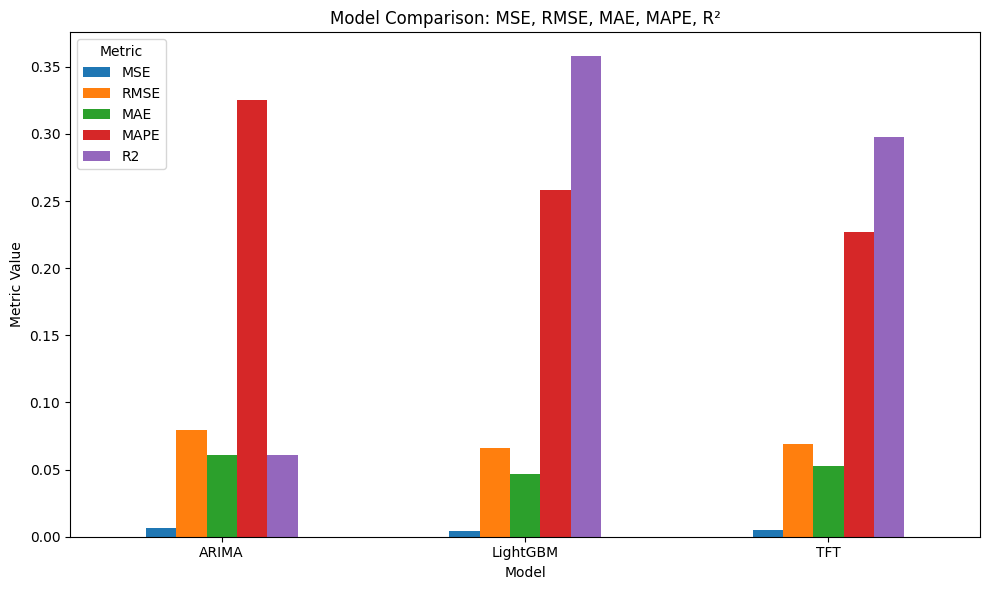

In [38]:
# ─── Extended Metrics + Grouped‐Bar Plot ─────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# assume preds_complete and truth_complete exist
results = []
for model in preds_complete.columns:
    y_pred = preds_complete[model]
    y_true = truth_complete

    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    results.append({
        "Model": model,
        "MSE":   mse,
        "RMSE":  rmse,
        "MAE":   mae,
        "MAPE":  mape,
        "R2":    r2
    })

metrics_df = pd.DataFrame(results).set_index("Model")
print(metrics_df, "\n")

# Plot grouped bars
ax = metrics_df.plot(
    kind="bar",
    figsize=(10, 6),
    rot=0
)
ax.set_title("Model Comparison: MSE, RMSE, MAE, MAPE, R²")
ax.set_ylabel("Metric Value")
ax.set_xlabel("Model")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()



Best ensemble weight w=0.56 gives R²=0.458

Ensemble metrics:
 MSE:  0.003653
 RMSE: 0.060442
 MAE:  0.046116
 MAPE: 0.231665
 R²:   0.457576

Updated metrics:
               MSE      RMSE       MAE      MAPE        R2
Model                                                     
ARIMA     0.006326  0.079539  0.060840  0.325051  0.060670
LightGBM  0.004326  0.065769  0.046721  0.258315  0.357748
TFT       0.004730  0.068778  0.052734  0.227173  0.297632
Ensemble  0.003653  0.060442  0.046116  0.231665  0.457576 



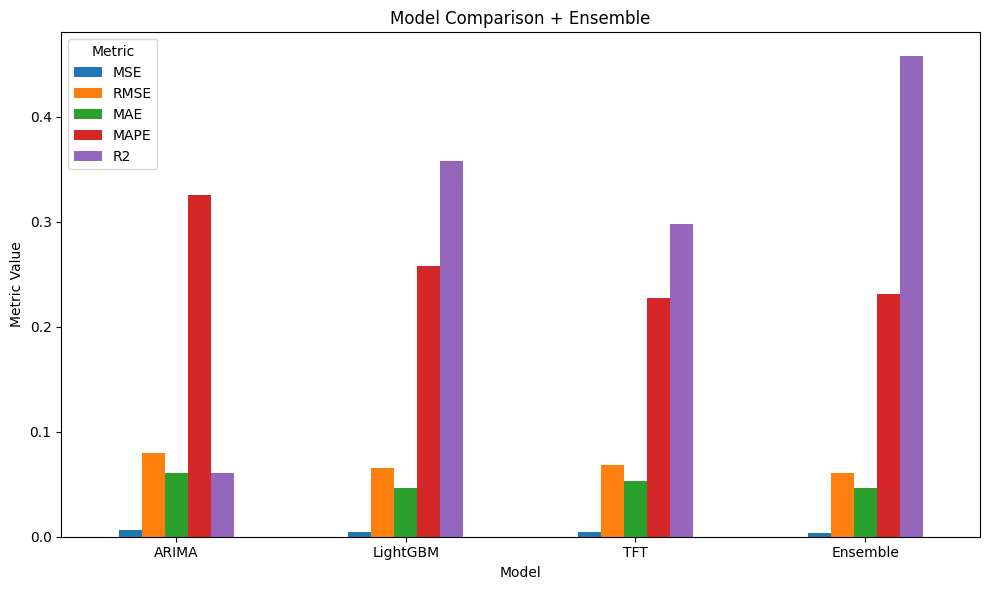

In [39]:
# ─── 6. Simple Ensemble of LightGBM + TFT ─────────────────────────────────
import numpy as np
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# preds_complete and truth_complete
lgb = preds_complete["LightGBM"]
tft = preds_complete["TFT"]
y   = truth_complete

# Find best weight w (ensemble = w*LGB + (1-w)*TFT) to maximize R2
best = {"r2": -np.inf, "w": None}
for w in np.linspace(0, 1, 101):
    ens = w * lgb + (1 - w) * tft
    r2  = r2_score(y, ens)
    if r2 > best["r2"]:
        best = {"r2": r2, "w": w}
print(f"Best ensemble weight w={best['w']:.2f} gives R²={best['r2']:.3f}")

# Compute full metrics for that ensemble
w = best["w"]
ens = w * lgb + (1 - w) * tft
mse   = mean_squared_error(y, ens)
rmse  = np.sqrt(mse)
mae   = mean_absolute_error(y, ens)
mape  = mean_absolute_percentage_error(y, ens)
r2    = best["r2"]

print("\nEnsemble metrics:")
print(f" MSE:  {mse:.6f}")
print(f" RMSE: {rmse:.6f}")
print(f" MAE:  {mae:.6f}")
print(f" MAPE: {mape:.6f}")
print(f" R²:   {r2:.6f}")

# Add to metrics table and re‐plot
ensemble_df = pd.DataFrame([{
    "Model": "Ensemble",
    "MSE":   mse,
    "RMSE":  rmse,
    "MAE":   mae,
    "MAPE":  mape,
    "R2":    r2
}]).set_index("Model")

metrics_df = pd.concat([metrics_df, ensemble_df])
print("\nUpdated metrics:")
print(metrics_df, "\n")

# Re‐plot grouped‐bar with the ensemble included
ax = metrics_df.plot(
    kind="bar",
    figsize=(10,6),
    rot=0
)
ax.set_title("Model Comparison + Ensemble")
ax.set_ylabel("Metric Value")
ax.set_xlabel("Model")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


**Note**: You may need to restart the Colab runtime after installing the library for the changes to take effect.